In [1]:
# importar bibliotecas

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint

import openpyxl 

In [2]:
def funcao_reacao_parcial (z, t):
    
    L, OD = z # Definir as variaveis
    
    # Constantes da reação

    V = 25.6 * (10**6) #m3
    H = 5.6 #m
    Os = 9.0 #mg/L
    v_s = 1 #m/d
    L_F4 = 1.5 #mg/L
    L_TD4 = 1.7 #mg/L
    L_TE10 = 1.3 #mg/L
    OD_F4 = 8 #mg/L
    OD_TD4 = 8 #mg/L
    OD_TE10 = 8 #mg/L
    kd = 1.5 #d-1
    ka = 0.3 #d-1
    k_sed = v_s/H
    k_ra = 0.05 #d-1
    k_n = 0.1 #d-1
    k_g = 0.15 #d-1
    r_ca = 50 #gC/mgChla
    r_oc = 2.67 #gO/gC
    r_on = 4.2 #gO/gN
    L_n = 0.157 #mg/L
    alpha = 0.0128 #mg/L
    L_part = 0.5 #adimensional
    SOD = 1 #gO2/m2
    pa = r_oc*r_ca*k_g*alpha #mgOD/L

    # Balanço hidrico

    Q_F4 = 2.0  * 86400 #* 1000 #m3/d
    Q_TD4 = 0.3 * 86400 #* 1000#m3/d
    Q_TE10 = 0.15  * 86400# * 1000#m3/d
       
    bal_hid = Q_F4 + Q_TD4 + Q_TE10  
   
    #Cargas externas

    carga_L = L_F4*Q_F4 + L_TD4*Q_TD4 + L_TE10*Q_TE10
    carga_OD = OD_F4*Q_F4 + OD_TD4*Q_TD4 + OD_TE10*Q_TE10
   
    # Definir as funções
    
    dLdt = - kd*L + r_ca*r_oc*k_ra*alpha - k_sed*(1-L_part)*L - (L/V)*bal_hid + carga_L/V   
    
    dODdt = -kd*L + ka*(Os-OD) - r_on*k_n*L_n - r_ca*r_oc*k_ra*alpha - r_ca*r_oc*k_ra*alpha - (SOD/H) + pa  - (OD/V)*bal_hid + carga_OD/V  

    return dLdt, dODdt

# Condições iniciais

L0_1 = 1.5 #mg/L
OD0_1 = 5.8 #mg/L
z0_1 = L0_1, OD0_1


# Passo no tempo
t = np.linspace(0,100,300)

C:\Users\Nathan\AppData\Local\Temp\ipykernel_15132\2108932512.py:16: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  ax1.grid(b=True, which='major', c='w', lw=2, ls='-')


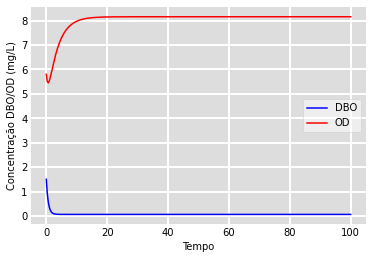

In [11]:
# Integrar as equações com odeint

funcao_teste = odeint(funcao_reacao_parcial, z0_1, t)
L1, OD1 = funcao_teste.T

# Plotar o resultado

fig1 = plt.figure(facecolor = 'w')
ax1 = fig1.add_subplot(111, facecolor='#dddddd', axisbelow=True)
ax1.plot (t, L1, 'b', label = 'DBO')
ax1.plot (t, OD1, 'r', label = 'OD')
ax1.set_xlabel ('Tempo')
ax1.set_ylabel ('Concentração DBO/OD (mg/L)')
ax1.yaxis.set_tick_params(length=0)
ax1.xaxis.set_tick_params(length=0)
ax1.grid(b=True, which='major', c='w', lw=2, ls='-')
legend1 = ax1.legend()
legend1.get_frame().set_alpha(0.5)
for spine in ('top', 'right', 'bottom', 'left'):
    ax1.spines[spine].set_visible(False)
plt.show()

In [2]:
# Correção dos dados disponíveis para os termos que variam ao longo do tempo

# Temperatura - ºC p/ Kelvin

def dados_reservatorio_interpolado(plotar=False):
    dados = pd.read_excel('https://github.com/CostaNathan/doctorate/blob/Modelos-de-dispersao-e-qualidade-da-agua/pasta_final/dados-para-interpolacao_final.xlsx?raw=true')
    
    colunas = ['OD (mg/L)', 'temperatura (ºC)', 'fosforo_total (ug/L)',
               'fosforo_reativo (ug/L)', 'nitrog_amoniacal (ug/L)', 'nitrog_total (ug/L)',
               'nitrito (ug/L)', 'nitrato (ug/L)']
    
    data_frame = pd.DataFrame(dados['data'])
    
    cont = 0
    for c in colunas:
        if cont == 0 or cont == 1:
            interpolacao = pd.DataFrame(dados[c]).interpolate()
            data_frame = data_frame.join(interpolacao)
        else:
            interpolacao = pd.DataFrame(dados[c] * 10 ** (- 3)).interpolate()
            data_frame = data_frame.join(interpolacao)
            
        cont += 1
    
    if plotar == True:
        nomes_ajustados = ['Oxigênio Dissolvido ($\mathrm{mgL}^{-1}$)', 'Temperatura (ºC)', 'Fósforo Total ($\mathrm{mgL}^{-1}$)',
                           'Fósforo Reativo ($\mathrm{mgL}^{-1}$)', 'Nitrogênio Amoniacal ($\mathrm{mgL}^{-1}$)', 'Nitrogênio Total ($\mathrm{mgL}^{-1}$)',
                           'Nitrito ($\mathrm{mgL}^{-1}$)', 'Nitrato ($\mathrm{mgL}^{-1}$)']

        for i in range(len(nomes_ajustados)):
            plt.figure(figsize=(7, 5), dpi=150)
            
            if i == 1:
                plt.ylabel('Temperatura (ºC)')
            else:
                plt.ylabel('Concentração ($\mathrm{mgL}^{-1}$)')
            
            plt.xlabel('Tempo (dias)')
            plt.plot(data_frame['data'], data_frame[colunas[i]], '-', color='black', label=nomes_ajustados[i])
            plt.xticks(rotation=45)
            plt.grid(linestyle='--')
            plt.legend(loc='best')
#             plt.savefig(f'/Users/matheus/Desktop/figuras/figura_{i}')
            plt.show()
            plt.close()
    
    return data_frame.dropna()

# dados_reservatorio_interpolado()['temperatura (ºC)']

In [3]:
# Termos da equação que variam ao longo do tempo com resultados conhecidos
# Os, temperatura, L_F4, L_TD4, L_TE10, OD_F4, OD_TD4, OD_TE10, kd, ka, k_sed, k_n, k_g, Q_F4, Q_TD4, Q_TE10

# #Teste 1 - Para isso, deve-se definir essas variáveis fora da função como uma lista ou array (depende da forma que for usado pra chamar a constante) e considerá-las dentro da função criada

# Termos que variam ao longo do tempo:

#Temperatura
Temp_reservatorio_celsius = dados_reservatorio_interpolado()['temperatura (ºC)']
Temp_reservatorio_kelvin = Temp_reservatorio_celsius + 273.15

#Oxigenio de saturação
Os_temp = -139.34411 + ((1.575701*(10**5))/Temp_reservatorio_kelvin) - ((6.642308*(10**7))/(Temp_reservatorio_kelvin**2)) + ((1.243800 * (10**10))/(Temp_reservatorio_kelvin**3)) - ((8.621949 * (10**11))/(Temp_reservatorio_kelvin**4))
Os_variando = np.exp(Os_temp)



In [4]:
def funcao_reacao_variando (z, t, Os_variando, kd_var, ka_var, kn_var, k_ra_var, SOD_var):
    
    L = z[0]
    OD = z[1] # Definir as variaveis
    
    # Constantes da reação

    V = 25.6 * (10**6) #m3
    H = 5.6 #m
    # Os = 8.0 #mg/L
    v_s = 1 #m/d
    L_F4 = 1.5 #mg/L
    L_TD4 = 1.7 #mg/L
    L_TE10 = 1.3 #mg/L
    OD_F4 = 8 #mg/L
    OD_TD4 = 8 #mg/L
    OD_TE10 = 8 #mg/L
    # kd = 1.5 #d-1
    # ka = 0.3 #d-1
    k_sed = v_s/H
    # k_ra = 0.05 #d-1
    # k_n = 0.1 #d-1
    k_g = 0.15 #d-1
    r_ca = 50 #gC/mgChla
    r_oc = 2.67 #gO/gC
    r_on = 4.2 #gO/gN
    L_n = 0.157 #mg/L
    alpha = 0.0128 #mg/L
    L_part = 0.5 #adimensional
    # SOD = 1 #gO2/m2
    pa = r_oc*r_ca*k_g*alpha #mgOD/L

    # Balanço hidrico

    Q_F4 = 2.0  * 86400 #* 1000 #m3/d
    Q_TD4 = 0.3 * 86400 #* 1000#m3/d
    Q_TE10 = 0.15  * 86400# * 1000#m3/d
       
    bal_hid = Q_F4 + Q_TD4 + Q_TE10  
   
    #Cargas externas

    carga_L = L_F4*Q_F4 + L_TD4*Q_TD4 + L_TE10*Q_TE10
    carga_OD = OD_F4*Q_F4 + OD_TD4*Q_TD4 + OD_TE10*Q_TE10
   
    # Definir as funções
    
    dLdt = - kd_var*L + r_ca*r_oc*k_ra_var*alpha - k_sed*(1-L_part)*L - (L/V)*bal_hid + carga_L/V   
    
    dODdt = -kd_var*L + ka_var*(Os_variando-OD) - r_on*kn_var*L_n - r_ca*r_oc*k_ra_var*alpha - r_ca*r_oc*k_ra_var*alpha - (SOD_var/H) + pa  - (OD/V)*bal_hid + carga_OD/V  # ka*(Os-OD) 

    return dLdt, dODdt

# Passo no tempo

n = 291
t = np.linspace(0,291,n)

# Variáveis vazias

L2 = np.empty_like(t)
OD2 = np.empty_like(t)

# Constantes variaveis

Os_variando_array = np.zeros(n)
Temp_reservatorio_celsius_array = np.zeros(n)


Os_variando_array[:] = Os_variando
Temp_reservatorio_celsius_array[:] = Temp_reservatorio_celsius

# Taxas de reação variaveis

kd = 1.5 
k_ds = 0.5
theta_kd = 1.047
kd_var =(kd * theta_kd **(Temp_reservatorio_celsius - 20)) * ((OD2/(k_ds+OD2)))
kd_var_array = np.zeros(n)
kd_var_array[:] = kd_var

ka = 0.3 
theta_ka = 1.024
ka_var = ka*theta_ka ** (Temp_reservatorio_celsius - 20)
ka_var_array = np.zeros(n)
ka_var_array[:] = ka_var

kn = 0.1
theta_kn = 1.08
kn_s = 1 #0.5 a 2
kn_var = (kn * theta_kn **(Temp_reservatorio_celsius - 20)) * ((OD2/(kn_s+OD2)))
kn_var_array = np.zeros(n)
kn_var_array[:] = kn_var

k_ra = 0.05
theta_k_ra = 1.08
k_ra_var = (k_ra * theta_k_ra **(Temp_reservatorio_celsius - 20))
k_ra_array = np.zeros(n)
k_ra_array [:] = k_ra_array

SOD = 1
theta_SOD = 1.08
SOD_var = SOD * theta_SOD **((Temp_reservatorio_celsius - 20))
SOD_var_array = np.zeros(n)
SOD_var_array[:] = SOD_var



# Condições iniciais

z0 = [1.5, 5.8]
L2[0] = z0[0]
OD2[0] = z0[1]



# L0_2 = 1.5 #mg/L
# OD0_2 = 5.8 #mg/L
# z0_2 = L0_2, OD0_2

In [ ]:
# Integrar as equações com odeint - para realizar isso com termos que variam ao longo do passo de tempo pode-se utilizar um for loop
for i in range (1, n):
    funcao_teste = odeint(funcao_reacao_variando, z0, t, args=(Os_variando_array[i], kd_var_array[i], ka_var_array[i], kn_var_array[i], k_ra_array[i], SOD_var_array[i]))
    L2[i] = funcao_teste[1][0]
    OD2[i] = funcao_teste [1][1]
    z0 = funcao_teste[1]


plt.plot(t, L2, label='DBO')
plt.plot(t, OD2, label='OD')
plt.legend()
plt.show()

funcao_teste

In [ ]:
def funcao_variando_nitro (z , t, Os_variando, kd_var, ka_var, kn_var, k_ra_var, SOD_var, k_oa_var, k_ni_var, k_dn_var):

    L = z[0]
    OD = z[1]
    No = z[2]
    Na = z[3]
    Nn = z[4]
    
    # Constantes da reação
    V = 25.6 * (10**6) #m3
    H = 5.6 #m
    # Os = 8.0 #mg/L
    v_s = 1 #m/d

    L_F4 = 1.5 #mg/L
    L_TD4 = 1.7 #mg/L
    L_TE10 = 1.3 #mg/L
    OD_F4 = 8 #mg/L
    OD_TD4 = 8 #mg/L
    OD_TE10 = 8 #mg/L
    No_F4= 0.1 #mg/L
    No_TD4 = 0.2 #mg/L
    No_TE10 = 0.15 #mg/L
    Na_F4 = 0.3 #mg/L
    Na_TD4 = 0.35 #mg/L
    Na_TE10 = 0.35 #mg/L
    Nn_F4 = 0.3 #mg/L
    Nn_TD4 = 0.3 #mg/L
    Nn_TE10 = 0.3 #mg/L

    # kd = 1.5 #d-1
    # ka = 0.3 #d-1
    k_sed = v_s/H
    # k_ra = 0.05 #d-1
    # k_n = 0.1 #d-1
    k_g = 1.3 #d-1
    # k_oa = 0.2 #d-1 [0.001 a 0.2]
    # k_ni = 0.09 #d-1 [0.09 a 0.13]
    # k_dn = 0.2 #d-1 [ 0 a 1]
    k_ea = 0.1 #d-1 [0.003 a 0.17]

    r_ca = 50 #gC/mgChla
    r_oc = 2.67 #gO/gC
    r_on = 4.2 #gO/gN
    r_na = 7 #gN/gChla [7 a 15]

    L_n = 0.157 #mg/L
    alpha = 0.0128 #mg/L
    L_part = 0.5 #adimensional
    f_nod = 1 
    f_on = 0.2 #adimensional
    # SOD = 1 #gO2/m2
    pa = r_oc*r_ca*k_g*alpha #mgOD/L

    # Balanço hidrico

    Q_F4 = 2.0  * 86400 #* 1000 #m3/d
    Q_TD4 = 0.3 * 86400 #* 1000#m3/d
    Q_TE10 = 0.15  * 86400# * 1000#m3/d
       
    bal_hid = Q_F4 + Q_TD4 + Q_TE10  
   
    #Cargas externas

    carga_L = L_F4*Q_F4 + L_TD4*Q_TD4 + L_TE10*Q_TE10
    carga_OD = OD_F4*Q_F4 + OD_TD4*Q_TD4 + OD_TE10*Q_TE10
    carga_No = No_F4*Q_F4 + No_TD4*Q_TD4 + No_TE10*Q_TE10
    carga_Na = Na_F4*Q_F4 + Na_TD4*Q_TD4 + Na_TE10*Q_TE10
    carga_Nn = Nn_F4*Q_F4 + Nn_TD4*Q_TD4 + Nn_TE10*Q_TE10

     # Definir as funções
    
    dLdt = - kd_var*L + r_ca*r_oc*k_ra_var*alpha - k_sed*(1-L_part)*L - (L/V)*bal_hid + carga_L/V   
    
    dODdt = -kd_var*L + ka_var*(Os_variando-OD) - r_on*kn_var*L_n - r_ca*r_oc*k_ra_var*alpha - r_ca*r_oc*k_ra_var*alpha - (SOD_var/H) + pa  - (OD/V)*bal_hid + carga_OD/V  # ka*(Os-OD) 

    dNodt = -k_oa_var*No - k_sed*(1-f_nod)*No + r_na*k_ra_var*f_on*alpha + r_na*k_ea*f_on*alpha + carga_No/V

    dNadt = k_oa_var*No - k_ni_var*Na + r_na*k_ra_var*(1-f_on)*alpha + r_na*k_ea*(1-f_on)*alpha + carga_Na/V # - r_na*k_g*alpha (da amonia negativa)

    dNndt = k_ni_var*Nn - k_dn_var*Nn + carga_Nn/V # - r_na*k_g*alpha

    return dLdt, dODdt, dNodt, dNadt, dNndt

# Variáveis vazias 

L3 = np.empty_like(t)
OD3 = np.empty_like(t)
No = np.empty_like(t)
Na = np.empty_like(t)
Nn = np.empty_like(t)

# Taxas de reação variaveis

kd = 0.3
k_ds = 0.5
theta_kd = 1.047
kd_var =(kd * theta_kd **(Temp_reservatorio_celsius - 20)) * ((OD3/(k_ds+OD3)))
kd_var_array = np.zeros(n)
kd_var_array[:] = kd_var

ka = 1.5
theta_ka = 1.024
ka_var = ka*theta_ka ** (Temp_reservatorio_celsius - 20)
ka_var_array = np.zeros(n)
ka_var_array[:] = ka_var

kn = 0.1
theta_kn = 1.08
kn_s = 1 #0.5 a 2
kn_var = (kn * theta_kn **(Temp_reservatorio_celsius - 20)) * ((OD3/(kn_s+OD3)))
kn_var_array = np.zeros(n)
kn_var_array[:] = kn_var

k_ra = 0.05
theta_k_ra = 1.08
k_ra_var = (k_ra * theta_k_ra **(Temp_reservatorio_celsius - 20))
k_ra_array = np.zeros(n)
k_ra_array [:] = k_ra_array

SOD = 1
theta_SOD = 1.08
SOD_var = SOD * theta_SOD **((Temp_reservatorio_celsius - 20))
SOD_var_array = np.zeros(n)
SOD_var_array[:] = SOD_var

k_oa = 0.2 
theta_koa = 1.08
k_oa_var = (k_oa * theta_koa **(Temp_reservatorio_celsius - 20))
k_oa_var_array = np.zeros(n)
k_oa_var_array[:] = k_oa_var

k_ni = 0.09
theta_kni = 1.08 
k_ni_var = (k_ni * theta_kni **(Temp_reservatorio_celsius - 20))
k_ni_var_array = np.zeros(n)
k_ni_var_array[:] = k_ni_var

k_dn = 0.2
theta_kdn = 1.045
k_dn_var = (k_dn * theta_kdn **(Temp_reservatorio_celsius - 20))
k_dn_var_array = np.zeros(n)
k_dn_var_array[:] = k_dn_var


# Condições iniciais

z_nit = [1.5, 5.8, 0.3, 0.157, 0.038]
L3[0] = z_nit[0]
OD3[0] = z_nit[1]
No[0] = z_nit[2]
Na[0] = z_nit[3]
Nn[0] = z_nit[4]

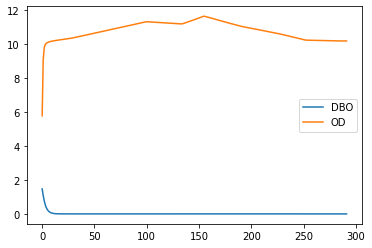

In [ ]:
for i in range (1, n):
    funcao_nit = odeint(funcao_variando_nitro, z_nit, t, args=(Os_variando_array[i], kd_var_array[i], ka_var_array[i], kn_var_array[i], k_ra_array[i], SOD_var_array[i], k_oa_var_array[i],k_ni_var_array[i], k_dn_var_array[i]))
    L3[i] = funcao_nit[1][0]
    OD3[i] = funcao_nit [1][1]
    No[i] = funcao_nit [1][2]
    Na[i] = funcao_nit [1][3]
    Nn[i] = funcao_nit [1][4]
    z_nit = funcao_nit[1]

plt.plot(t, L3, label='DBO')
plt.plot(t, OD3, label='OD')
plt.legend()
plt.show()

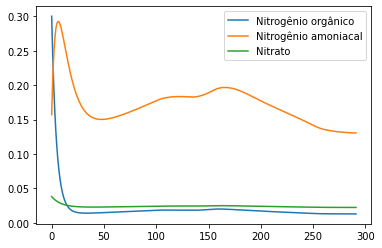

In [ ]:
plt.plot(t, No, label='Nitrogênio orgânico')
plt.plot(t, Na, label='Nitrogênio amoniacal')
plt.plot(t, Nn, label='Nitrato')
plt.legend()
plt.show()

# adição do crescimento do fitoplancton deixou amonia negativa 

In [5]:
def funcao_variando_fosf (z , t, Os_variando, kd_var, ka_var, kn_var, k_ra_var, SOD_var, k_oa_var, k_ni_var, k_dn_var, k_mineral_var):
    L = z[0]
    OD = z[1]
    No = z[2]
    Na = z[3]
    Nn = z[4]
    P_org = z[5]
    P_in = z[6]
    
    # Constantes da reação
    V = 25.6 * (10**6) #m3
    H = 5.6 #m
    # Os = 8.0 #mg/L
    v_s = 1 #m/d [0.2 a 2.3]

    L_F4 = 1.5 #mg/L
    L_TD4 = 1.7 #mg/L
    L_TE10 = 1.3 #mg/L
    OD_F4 = 8 #mg/L
    OD_TD4 = 8 #mg/L
    OD_TE10 = 8 #mg/L
    No_F4= 0.1 #mg/L
    No_TD4 = 0.2 #mg/L
    No_TE10 = 0.15 #mg/L
    Na_F4 = 0.3 #mg/L
    Na_TD4 = 0.35 #mg/L
    Na_TE10 = 0.35 #mg/L
    Nn_F4 = 0.3 #mg/L
    Nn_TD4 = 0.3 #mg/L
    Nn_TE10 = 0.3 #mg/L
    P_org_F4 = 0.02 #mg/L
    P_org_TD4 = 0.015 #mg/L
    P_org_TE10 = 0.02 #mg/L
    P_in_F4 = 0.01 #mg/L
    P_in_TD4 = 0.015 #mg/L
    P_in_TE10 = 0.01 #mg/L 

    # kd = 1.5 #d-1
    # ka = 0.3 #d-1
    k_sed = v_s/H
    # k_ra = 0.05 #d-1
    # k_n = 0.1 #d-1
    k_g = 1.3 #d-1
    # k_oa = 0.2 #d-1 
    # k_ni = 0.09 #d-1 
    # k_dn = 0.2 #d-1 
    k_ea = 0.1 #d-1 
    # k_mineral = 0.1 #d-1 
   

    r_ca = 50 #gC/mgChla
    r_oc = 2.67 #gO/gC
    r_on = 4.2 #gO/gN
    r_na = 7 #gN/gChla [7 a 15]
    r_pa = 0.5 # gP/gChla [0.5 a 1]

    L_n = 0.157 #mg/L
    alpha = 0.0128 #mg/L
    L_part = 0.5 #adimensional
    f_nod = 1 
    f_on = 0.2 #adimensional
    f_op = 0.1 #adimensional [0.1 a 0.9]
    # SOD = 1 #gO2/m2
    pa = r_oc*r_ca*k_g*alpha #mgOD/L

    # Balanço hidrico

    Q_F4 = 2.0  * 86400 #* 1000 #m3/d
    Q_TD4 = 0.3 * 86400 #* 1000#m3/d
    Q_TE10 = 0.15  * 86400# * 1000#m3/d
       
    bal_hid = Q_F4 + Q_TD4 + Q_TE10  
   
    #Cargas externas

    carga_L = L_F4*Q_F4 + L_TD4*Q_TD4 + L_TE10*Q_TE10
    carga_OD = OD_F4*Q_F4 + OD_TD4*Q_TD4 + OD_TE10*Q_TE10
    carga_No = No_F4*Q_F4 + No_TD4*Q_TD4 + No_TE10*Q_TE10
    carga_Na = Na_F4*Q_F4 + Na_TD4*Q_TD4 + Na_TE10*Q_TE10
    carga_Nn = Nn_F4*Q_F4 + Nn_TD4*Q_TD4 + Nn_TE10*Q_TE10
    carga_P_org = P_org_F4*Q_F4 + P_org_TD4*Q_TD4 + P_org_TE10*Q_TE10
    carga_P_in = P_in_F4*Q_F4 + P_in_TD4*Q_TD4 + P_in_TE10*Q_TE10

    # Definir as funções
    
    dLdt = - kd_var*L + r_ca*r_oc*k_ra_var*alpha - k_sed*(1-L_part)*L - (L/V)*bal_hid + carga_L/V   
    
    dODdt = -kd_var*L + ka_var*(Os_variando-OD) - r_on*kn_var*L_n - r_ca*r_oc*k_ra_var*alpha - r_ca*r_oc*k_ra_var*alpha - (SOD_var/H) + pa  - (OD/V)*bal_hid + carga_OD/V  # ka*(Os-OD) 

    dNodt = -k_oa_var*No - k_sed*(1-f_nod)*No + r_na*k_ra_var*f_on*alpha + r_na*k_ea*f_on*alpha + carga_No/V - (No/V)*bal_hid

    dNadt = k_oa_var*No - k_ni_var*Na + r_na*k_ra_var*(1-f_on)*alpha + r_na*k_ea*(1-f_on)*alpha + carga_Na/V - (Na/V)*bal_hid - Na*r_na*k_g*alpha # (da amonia negativa)

    dNndt = k_ni_var*Nn - k_dn_var*Nn + carga_Nn/V - (Nn/V)*bal_hid #-(1-Na)*r_na*k_g*alpha
    
    dP_orgdt = -k_mineral_var*P_org + r_pa*k_ra_var*f_op*alpha + r_pa*k_ea*f_op*alpha + carga_P_org/V

    dP_indt = k_mineral_var*P_org - k_sed*P_in +r_pa*k_ra_var*(1-f_op)*alpha + r_pa*k_ea*(1-f_op)*alpha + carga_P_in/V

    return dLdt, dODdt, dNodt, dNadt, dNndt, dP_orgdt, dP_indt

    # Variáveis vazias 

L4 = np.empty_like(t)
OD4 = np.empty_like(t)
No4 = np.empty_like(t)
Na4 = np.empty_like(t)
Nn4 = np.empty_like(t)
P_org = np.empty_like(t) 
P_in = np.empty_like(t)

# Taxas de reação variaveis

kd = 1.5 #[0.01 a 1.5]
k_ds = 0.5
theta_kd = 1.047
kd_var =(kd * theta_kd **(Temp_reservatorio_celsius - 20)) * ((OD4/(k_ds+OD4)))
kd_var_array = np.zeros(n)
kd_var_array[:] = kd_var

ka = 1.3 #[0.1 a 5]
theta_ka = 1.024
ka_var = ka*(theta_ka ** (Temp_reservatorio_celsius - 20))
ka_var_array = np.zeros(n)
ka_var_array[:] = ka_var

kn = 0.1 
theta_kn = 1.08
kn_s = 1 #[0.5 a 2]
kn_var = (kn * theta_kn **(Temp_reservatorio_celsius - 20)) * ((OD4/(kn_s+OD4)))
kn_var_array = np.zeros(n)
kn_var_array[:] = kn_var

k_ra = 0.05
theta_k_ra = 1.08
k_ra_var = (k_ra * theta_k_ra **(Temp_reservatorio_celsius - 20))
k_ra_array = np.zeros(n)
k_ra_array [:] = k_ra_array

SOD = 1 # [0.2 a 4]
theta_SOD = 1.08
SOD_var = SOD * theta_SOD **((Temp_reservatorio_celsius - 20))
SOD_var_array = np.zeros(n)
SOD_var_array[:] = SOD_var

k_oa = 0.2 #[0.001 a 0.2]
theta_koa = 1.08
k_oa_var = (k_oa * theta_koa **(Temp_reservatorio_celsius - 20))
k_oa_var_array = np.zeros(n)
k_oa_var_array[:] = k_oa_var

k_ni = 0.09 #[0.09 a 0.13]
theta_kni = 1.08 
k_ni_var = (k_ni * theta_kni **(Temp_reservatorio_celsius - 20))
k_ni_var_array = np.zeros(n)
k_ni_var_array[:] = k_ni_var

k_dn = 0.2 #[0 a 1]
theta_kdn = 1.045
k_dn_var = (k_dn * theta_kdn **(Temp_reservatorio_celsius - 20))
k_dn_var_array = np.zeros(n)
k_dn_var_array[:] = k_dn_var

k_mineral = 0.8 #[0.001 a 0.8]
theta_k_mineral = 1.08
k_mineral_s = 1 #d-1
alpha = 0.0128
k_mineral_var = (k_mineral*theta_k_mineral**(Temp_reservatorio_celsius - 20))*((alpha/(alpha+k_mineral_s)))
k_mineral_var_array = np.zeros(n)
k_mineral_var_array[:] = k_mineral_var 

# Condições iniciais

z_fosf = [1.5, 5.8, 0.3, 0.157, 0.038, 0.0189, 0.0039 ]
L4[0] = z_fosf[0]
OD4[0] = z_fosf[1]
No4[0] = z_fosf[2]
Na4[0] = z_fosf[3]
Nn4[0] = z_fosf[4]
P_org[0] = z_fosf[5]
P_in[0] = z_fosf[6]



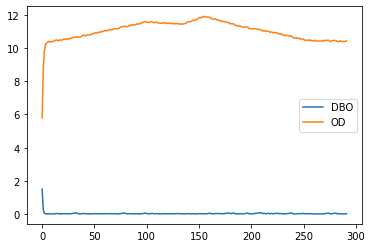

In [6]:
for i in range (1, n):
    funcao_fosf = odeint(funcao_variando_fosf, z_fosf, t, args=(Os_variando_array[i], kd_var_array[i], ka_var_array[i], kn_var_array[i], k_ra_array[i], SOD_var_array[i], k_oa_var_array[i],k_ni_var_array[i], k_dn_var_array[i], k_mineral_var_array[i]))
    L4[i] = funcao_fosf [1][0]
    OD4[i] = funcao_fosf [1][1]
    No4[i] = funcao_fosf [1][2]
    Na4[i] = funcao_fosf [1][3]
    Nn4[i] = funcao_fosf [1][4]
    P_org[i] = funcao_fosf [1][5]
    P_in[i] = funcao_fosf [1][6]
    z_fosf = funcao_fosf[1]

plt.plot(t, L4, label='DBO')
plt.plot(t, OD4, label='OD')
plt.legend()
plt.show()

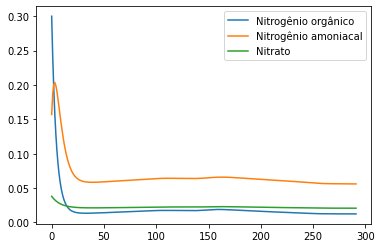

In [7]:
plt.plot(t, No4, label='Nitrogênio orgânico')
plt.plot(t, Na4, label='Nitrogênio amoniacal')
plt.plot(t, Nn4, label='Nitrato')
plt.legend()
plt.show()


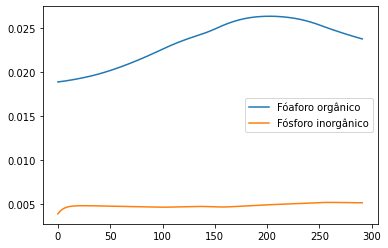

In [8]:
plt.plot(t, P_org, label='Fóaforo orgânico')
plt.plot(t, P_in, label='Fósforo inorgânico')
plt.legend()
plt.show()

In [9]:
# Adicionando a variação no balanço hídrico
# Para isso, considera-se a variação das vazões e concentrações nos tributários 

# Para a variação das concentrações
def dados_tributarios():
    df_trib_F4 = pd.read_excel('https://github.com/CostaNathan/doctorate/blob/Modelos-de-dispersao-e-qualidade-da-agua/pasta_final/dados-para-interpolacao_final.xlsx?raw=true', 'trib_F4').reset_index()
    
    df_trib_TE_10 = pd.read_excel('https://github.com/CostaNathan/doctorate/blob/Modelos-de-dispersao-e-qualidade-da-agua/pasta_final/dados-para-interpolacao_final.xlsx?raw=true', 'trib_TE_10').reset_index()
    
    df_trib_TD_4 = pd.read_excel('https://github.com/CostaNathan/doctorate/blob/Modelos-de-dispersao-e-qualidade-da-agua/pasta_final/dados-para-interpolacao_final.xlsx?raw=true', 'trib_TD_4').reset_index()
    
    df_trib_F5 = pd.read_excel('https://github.com/CostaNathan/doctorate/blob/Modelos-de-dispersao-e-qualidade-da-agua/pasta_final/dados-para-interpolacao_final.xlsx?raw=true', 'trib_F5').reset_index()

    colunas = ['Oxigênio dissolvido', 'temperatura',
               'Fósforo total', 'Fósforo reativo', 'Nitrogênio amonical',
               'Nitrogênio total', 'Nitrito', 'Nitrato']
    
    lista = [df_trib_F4, df_trib_TE_10, df_trib_TD_4, df_trib_F5]
    
    nomes = ['df_trib_F4', 'df_trib_TE_10', 'df_trib_TD_4', 'df_trib_F5']
    
    dicionario = {}
    
    cont = 0
    for i in range(len(lista)):
        data_frame = pd.DataFrame(lista[i]['data'])
        
        for c in colunas:
            if cont == 0 or cont == 1:
                interpolacao = pd.DataFrame(lista[i][c]).interpolate()
            else:
                interpolacao = pd.DataFrame(lista[i][c] * 10 ** (- 3)).interpolate()
                # interpolacao = pd.DataFrame(lista[i][c]).interpolate()
            
            data_frame = data_frame.join(pd.DataFrame(interpolacao))
            cont += 1
        
        cont = 0 
        
        dicionario[nomes[i]] = data_frame.dropna()
    
    return dicionario
            

display(dados_tributarios()['df_trib_F4'])
display(dados_tributarios()['df_trib_TE_10'])
display(dados_tributarios()['df_trib_TD_4'])


,data,Oxigênio dissolvido,temperatura,Fósforo total,Fósforo reativo,Nitrogênio amonical,Nitrogênio total,Nitrito,Nitrato
15,2010-03-16,9.000000,21.600000,0.042000,0.009460,0.141000,0.182000,0.019180,0.278000
16,2010-03-17,9.007143,21.489286,0.041888,0.009366,0.139079,0.182179,0.018714,0.273107
17,2010-03-18,9.014286,21.378571,0.041775,0.009272,0.137157,0.182357,0.018248,0.268214
18,2010-03-19,9.021429,21.267857,0.041663,0.009178,0.135236,0.182536,0.017782,0.263321
19,2010-03-20,9.028571,21.157143,0.041550,0.009084,0.133314,0.182714,0.017316,0.258429
...,...,...,...,...,...,...,...,...,...
301,2010-12-27,6.510000,21.900000,0.034700,0.012200,0.496600,0.281000,0.304700,0.012900
302,2010-12-28,6.510000,21.900000,0.034700,0.012200,0.496600,0.281000,0.304700,0.012900
303,2010-12-29,6.510000,21.900000,0.034700,0.012200,0.496600,0.281000,0.304700,0.012900
304,2010-12-30,6.510000,21.900000,0.034700,0.012200,0.496600,0.281000,0.304700,0.012900


,data,Oxigênio dissolvido,temperatura,Fósforo total,Fósforo reativo,Nitrogênio amonical,Nitrogênio total,Nitrito,Nitrato
15,2010-03-16,8.300000,21.200000,0.027600,0.004120,0.373000,0.182000,0.009750,0.293000
16,2010-03-17,8.303571,21.117857,0.028504,0.004348,0.364643,0.182286,0.010216,0.287714
17,2010-03-18,8.307143,21.035714,0.029407,0.004575,0.356286,0.182571,0.010682,0.282429
18,2010-03-19,8.310714,20.953571,0.030311,0.004803,0.347929,0.182857,0.011148,0.277143
19,2010-03-20,8.314286,20.871429,0.031214,0.005030,0.339571,0.183143,0.011614,0.271857
...,...,...,...,...,...,...,...,...,...
301,2010-12-27,6.810000,22.300000,0.030000,0.015300,0.478700,0.355100,0.448600,0.008900
302,2010-12-28,6.810000,22.300000,0.030000,0.015300,0.478700,0.355100,0.448600,0.008900
303,2010-12-29,6.810000,22.300000,0.030000,0.015300,0.478700,0.355100,0.448600,0.008900
304,2010-12-30,6.810000,22.300000,0.030000,0.015300,0.478700,0.355100,0.448600,0.008900


,data,Oxigênio dissolvido,temperatura,Fósforo total,Fósforo reativo,Nitrogênio amonical,Nitrogênio total,Nitrito,Nitrato
15,2010-03-16,8.300000,20.900000,0.027100,0.006660,0.359000,0.192000,0.004970,0.306000
16,2010-03-17,8.307143,20.832143,0.027135,0.006782,0.348957,0.191857,0.005138,0.300321
17,2010-03-18,8.314286,20.764286,0.027171,0.006904,0.338914,0.191714,0.005306,0.294643
18,2010-03-19,8.321429,20.696429,0.027206,0.007026,0.328871,0.191571,0.005475,0.288964
19,2010-03-20,8.328571,20.628571,0.027241,0.007149,0.318829,0.191429,0.005643,0.283286
...,...,...,...,...,...,...,...,...,...
301,2010-12-27,6.320000,21.300000,0.015500,0.022200,0.492200,0.349600,0.441700,0.013800
302,2010-12-28,6.320000,21.300000,0.015500,0.022200,0.492200,0.349600,0.441700,0.013800
303,2010-12-29,6.320000,21.300000,0.015500,0.022200,0.492200,0.349600,0.441700,0.013800
304,2010-12-30,6.320000,21.300000,0.015500,0.022200,0.492200,0.349600,0.441700,0.013800


In [12]:
def funcao_variando_bal_hid (z , t, Os_variando, kd_var, ka_var, kn_var, k_ra_var, SOD_var, k_oa_var, k_ni_var, k_dn_var, k_mineral_var):
    L = z[0]
    OD = z[1]
    No = z[2]
    Na = z[3]
    Nn = z[4]
    P_org = z[5]
    P_in = z[6]
    
    # Constantes da reação
    V = 25.6 * (10**6) #m3
    H = 5.6 #m
    # Os = 8.0 #mg/L
    v_s = 1 #m/d [0.2 a 2.3]

    L_F4 = 1.5 #mg/L
    L_TD4 = 1.7 #mg/L
    L_TE10 = 1.3 #mg/L
    OD_F4 = 8 #mg/L
    OD_TD4 = 8 #mg/L
    OD_TE10 = 8 #mg/L
    No_F4= 0.1 #mg/L
    No_TD4 = 0.2 #mg/L
    No_TE10 = 0.15 #mg/L
    Na_F4 = 0.3 #mg/L
    Na_TD4 = 0.35 #mg/L
    Na_TE10 = 0.35 #mg/L
    Nn_F4 = 0.3 #mg/L
    Nn_TD4 = 0.3 #mg/L
    Nn_TE10 = 0.3 #mg/L
    P_org_F4 = 0.02 #mg/L
    P_org_TD4 = 0.015 #mg/L
    P_org_TE10 = 0.02 #mg/L
    P_in_F4 = 0.01 #mg/L
    P_in_TD4 = 0.015 #mg/L
    P_in_TE10 = 0.01 #mg/L 

    # kd = 1.5 #d-1
    # ka = 0.3 #d-1
    k_sed = v_s/H
    # k_ra = 0.05 #d-1
    # k_n = 0.1 #d-1
    k_g = 1.3 #d-1
    # k_oa = 0.2 #d-1 
    # k_ni = 0.09 #d-1 
    # k_dn = 0.2 #d-1 
    k_ea = 0.1 #d-1 
    # k_mineral = 0.1 #d-1 
   

    r_ca = 50 #gC/mgChla
    r_oc = 2.67 #gO/gC
    r_on = 4.2 #gO/gN
    r_na = 7 #gN/gChla [7 a 15]
    r_pa = 0.5 # gP/gChla [0.5 a 1]

    L_n = 0.157 #mg/L
    alpha = 0.0128 #mg/L
    L_part = 0.5 #adimensional
    f_nod = 1 
    f_on = 0.2 #adimensional
    f_op = 0.1 #adimensional [0.1 a 0.9]
    # SOD = 1 #gO2/m2
    pa = r_oc*r_ca*k_g*alpha #mgOD/L

    # Balanço hidrico

    Q_F4 = 2.0  * 86400 #* 1000 #m3/d
    Q_TD4 = 0.3 * 86400 #* 1000#m3/d
    Q_TE10 = 0.15  * 86400# * 1000#m3/d
       
    bal_hid = Q_F4 + Q_TD4 + Q_TE10  
   
    #Cargas externas

    carga_L = L_F4*Q_F4 + L_TD4*Q_TD4 + L_TE10*Q_TE10
    carga_OD = OD_F4*Q_F4 + OD_TD4*Q_TD4 + OD_TE10*Q_TE10
    carga_No = No_F4*Q_F4 + No_TD4*Q_TD4 + No_TE10*Q_TE10
    carga_Na = Na_F4*Q_F4 + Na_TD4*Q_TD4 + Na_TE10*Q_TE10
    carga_Nn = Nn_F4*Q_F4 + Nn_TD4*Q_TD4 + Nn_TE10*Q_TE10
    carga_P_org = P_org_F4*Q_F4 + P_org_TD4*Q_TD4 + P_org_TE10*Q_TE10
    carga_P_in = P_in_F4*Q_F4 + P_in_TD4*Q_TD4 + P_in_TE10*Q_TE10

    # Definir as funções
    
    dLdt = - kd_var*L + r_ca*r_oc*k_ra_var*alpha - k_sed*(1-L_part)*L - (L/V)*bal_hid + carga_L/V   
    
    dODdt = -kd_var*L + ka_var*(Os_variando-OD) - r_on*kn_var*L_n - r_ca*r_oc*k_ra_var*alpha - r_ca*r_oc*k_ra_var*alpha - (SOD_var/H) + pa  - (OD/V)*bal_hid + carga_OD/V  # ka*(Os-OD) 

    dNodt = -k_oa_var*No - k_sed*(1-f_nod)*No + r_na*k_ra_var*f_on*alpha + r_na*k_ea*f_on*alpha + carga_No/V - (No/V)*bal_hid

    dNadt = k_oa_var*No - k_ni_var*Na + r_na*k_ra_var*(1-f_on)*alpha + r_na*k_ea*(1-f_on)*alpha + carga_Na/V - (Na/V)*bal_hid - Na*r_na*k_g*alpha # (da amonia negativa)

    dNndt = k_ni_var*Nn - k_dn_var*Nn + carga_Nn/V - (Nn/V)*bal_hid #-(1-Na)*r_na*k_g*alpha
    
    dP_orgdt = -k_mineral_var*P_org + r_pa*k_ra_var*f_op*alpha + r_pa*k_ea*f_op*alpha + carga_P_org/V

    dP_indt = k_mineral_var*P_org - k_sed*P_in +r_pa*k_ra_var*(1-f_op)*alpha + r_pa*k_ea*(1-f_op)*alpha + carga_P_in/V

    return dLdt, dODdt, dNodt, dNadt, dNndt, dP_orgdt, dP_indt


In [ ]:
# Variáveis vazias 

L5 = np.empty_like(t)
OD5 = np.empty_like(t)
No5 = np.empty_like(t)
Na5 = np.empty_like(t)
Nn5 = np.empty_like(t)
P_org5 = np.empty_like(t) 
P_in5 = np.empty_like(t)

# Taxas de reação variaveis

kd = 1.5 #[0.01 a 1.5]
k_ds = 0.5
theta_kd = 1.047
kd_var =(kd * theta_kd **(Temp_reservatorio_celsius - 20)) * ((OD4/(k_ds+OD4)))
kd_var_array = np.zeros(n)
kd_var_array[:] = kd_var

ka = 1.3 #[0.1 a 5]
theta_ka = 1.024
ka_var = ka*(theta_ka ** (Temp_reservatorio_celsius - 20))
ka_var_array = np.zeros(n)
ka_var_array[:] = ka_var

kn = 0.1 
theta_kn = 1.08
kn_s = 1 #[0.5 a 2]
kn_var = (kn * theta_kn **(Temp_reservatorio_celsius - 20)) * ((OD4/(kn_s+OD4)))
kn_var_array = np.zeros(n)
kn_var_array[:] = kn_var

k_ra = 0.05
theta_k_ra = 1.08
k_ra_var = (k_ra * theta_k_ra **(Temp_reservatorio_celsius - 20))
k_ra_array = np.zeros(n)
k_ra_array [:] = k_ra_array

SOD = 1 # [0.2 a 4]
theta_SOD = 1.08
SOD_var = SOD * theta_SOD **((Temp_reservatorio_celsius - 20))
SOD_var_array = np.zeros(n)
SOD_var_array[:] = SOD_var

k_oa = 0.2 #[0.001 a 0.2]
theta_koa = 1.08
k_oa_var = (k_oa * theta_koa **(Temp_reservatorio_celsius - 20))
k_oa_var_array = np.zeros(n)
k_oa_var_array[:] = k_oa_var

k_ni = 0.09 #[0.09 a 0.13]
theta_kni = 1.08 
k_ni_var = (k_ni * theta_kni **(Temp_reservatorio_celsius - 20))
k_ni_var_array = np.zeros(n)
k_ni_var_array[:] = k_ni_var

k_dn = 0.2 #[0 a 1]
theta_kdn = 1.045
k_dn_var = (k_dn * theta_kdn **(Temp_reservatorio_celsius - 20))
k_dn_var_array = np.zeros(n)
k_dn_var_array[:] = k_dn_var

k_mineral = 0.8 #[0.001 a 0.8]
theta_k_mineral = 1.08
k_mineral_s = 1 #d-1
alpha = 0.0128
k_mineral_var = (k_mineral*theta_k_mineral**(Temp_reservatorio_celsius - 20))*((alpha/(alpha+k_mineral_s)))
k_mineral_var_array = np.zeros(n)
k_mineral_var_array[:] = k_mineral_var 

# Concentrações dos tributários variando

OD_F4_array = np.zeros(n)
OD_F4_array[:] = dados_tributarios()['df_trib_F4']['Oxigênio dissolvido']
# OD_F4_array

OD_TD4_array = np.zeros(n)
OD_TD4_array[:] = dados_tributarios()['df_trib_TD_4']['Oxigênio dissolvido']
# OD_TD4_array

OD_TE10_array = np.zeros(n)
OD_TE10_array[:] = dados_tributarios()['df_trib_TE_10']['Oxigênio dissolvido']

No_F4_array = np.zeros(n)
No_F4_array[:] = dados_tributarios()['df_trib_F4']['Nitrogênio amonical']
# OD_F4_array

No_TD4_array = np.zeros(n)
No_TD4_array[:] = dados_tributarios()['df_trib_TD_4']['Nitrogênio amonical']
# OD_TD4_array

No_TE10_array = np.zeros(n)
No_TE10_array[:] = dados_tributarios()['df_trib_TE_10']['Nitrogênio amonical']

Na_F4_array = np.zeros(n)
Na_F4_array[:] = dados_tributarios()['df_trib_F4']['Nitrogênio total']

Na_TD4_array = np.zeros(n)
Na_TD4_array[:] = dados_tributarios()['df_trib_TD_4']['Nitrogênio total']
# OD_TD4_array

Na_TE10_array = np.zeros(n)
Na_TE10_array[:] = dados_tributarios()['df_trib_TE_10']['Nitrogênio total']

Nn_F4_array = np.zeros(n)
Nn_F4_array[:] = dados_tributarios()['df_trib_F4']['Nitrato']

Nn_TD4_array = np.zeros(n)
Nn_TD4_array[:] = dados_tributarios()['df_trib_TD_4']['Nitrato']
# OD_TD4_array

Nn_TE10_array = np.zeros(n)
Nn_TE10_array[:] = dados_tributarios()['df_trib_TE_10']['Nitrato']

P_org_F4_array = np.zeros(n)
P_org_F4_array[:] = dados_tributarios()['df_trib_F4']['Fósforo total']

P_org_TD4_array = np.zeros(n)
P_org_TD4_array[:] = dados_tributarios()['df_trib_TD_4']['Fósforo total']
# OD_TD4_array

P_org_TE10_array = np.zeros(n)
P_org_TE10_array[:] = dados_tributarios()['df_trib_TE_10']['Fósforo total']


P_in_F4_array = np.zeros(n)
P_in_F4_array[:] = dados_tributarios()['df_trib_F4']['Fósforo reativo']

P_in_TD4_array = np.zeros(n)
P_in_TD4_array[:] = dados_tributarios()['df_trib_TD_4']['Fósforo reativo']
# OD_TD4_array

P_in_TE10_array = np.zeros(n)
P_in_TE10_array[:] = dados_tributarios()['df_trib_TE_10']['Fósforo reativo']

# Variação da vazão + balanço hídrico

# Condições iniciais

z_bal_hid = [1.5, 5.8, 0.3, 0.157, 0.038, 0.0189, 0.0039 ]
L5[0] = z_bal_hid[0]
OD5[0] = z_bal_hid[1]
No5[0] = z_bal_hid[2]
Na5[0] = z_bal_hid[3]
Nn5[0] = z_bal_hid[4]
P_org5[0] = z_bal_hid[5]
P_in5[0] = z_bal_hid[6]


In [ ]:
for i in range (1, n):
    funcao_bal_hid = odeint(funcao_variando_bal_hid, z_fosf, t, args=(Os_variando_array[i], kd_var_array[i], ka_var_array[i], kn_var_array[i], k_ra_array[i], SOD_var_array[i], k_oa_var_array[i],k_ni_var_array[i], k_dn_var_array[i], k_mineral_var_array[i]))
    L5[i] = funcao_fosf [1][0]
    OD5[i] = funcao_fosf [1][1]
    No5[i] = funcao_fosf [1][2]
    Na5[i] = funcao_fosf [1][3]
    Nn5[i] = funcao_fosf [1][4]
    P_org5[i] = funcao_fosf [1][5]
    P_in5[i] = funcao_fosf [1][6]
    z_bal_hid = funcao_fosf[1]